# Project 3: Web Application Programming Interface (API) & Natural Language Processing (NLP)

### Part 3

----

### Contents

[**Part 1**](../code/1_data_scraping.ipynb):

1. Data Scraping

[**Part 2**](../code/2_data_cleaning_eda.ipynb):

2. Data Cleaning
3. Preprocessing
4. Exploratory Data Analysis

**Part 3** (This workbook):

5. [Model Selection](#5.Model-Selection)
6. [Conclusion and Recommendations](#6.Conclusion-and-Recommendations)

## 5.Model Selection

In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import scipy.stats as stats

# Data scraping 
import requests

# Visual
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Pre-processing
#!pip install emoji 
import emoji
#!pip install nltk
import nltk
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
#!pip install regex
import re

# Modelling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, \
                            accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix

# NLP
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string

# Others
import time
import datetime as dt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 100)

import warnings 
warnings.filterwarnings('ignore')

Referring back to the problem statement, the objective of the model is to predict which of the two subreddits (r/Samsung or r/Apple) does a post belong to (i.e. binary classification problem). 

From the data inspection and EDA, the words in the 'text' column, which consists of contents combined from 'title' and 'selftext', seem to have some predictive value. Therefore, we will use the 'text' column as the predictor X-variable in our attempt to predict the target Y-variable, 'is_samsung'. 

We will employ a range of supervised learning techniques below with data vectorized using **CountVectorizer** and **TfidVectorizer** (Term Frequency Inverse Document Frequency Vectorizer), starting with the default hyperparameters before performing tuning using Grid Search CV: 
- Logistic Regression;
- Multinomial Naive Bayes Classifier; and
- Random Forest Classifier


In [2]:
# Load data
df = pd.read_csv('../data/df.csv', low_memory = False)

In [3]:
# Check shape of df
df.shape

(14359, 12)

In [4]:
# Create feature matrix (X) and target (y)
X = df['text']
y = df['is_samsung']

In [5]:
# Check if our classes are balance
y.value_counts(normalize = True)

0    0.507765
1    0.492235
Name: is_samsung, dtype: float64

In [6]:
# Perform Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=42, 
                                                    test_size= 0.25,  # by default, test_size = 0.25
                                                    shuffle=True,    # shuffling df because r/Samsung appears at the top while r/Apple appears at the bottom
                                                    stratify=y)      # stratifying is applied to mitigate imbalanced classes

In [7]:
# Check train and test data
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(10769,)
(3590,)
(10769,)
(3590,)


### 5.1.Baseline Model

Our baseline model is set up using the normalized value of y_train. We will evaluate the performance of the selected model by comparing the accuracy score of the predictions against this baseline model. 

The baseline model would predict class 0 (r/Apple) for all posts (since it is > 0.5), and it would be accurate about 50.7799% of the time. 

In [8]:
# Check Baseline Model accuracy score on y_test
y_test.value_counts(normalize = True)

0    0.507799
1    0.492201
Name: is_samsung, dtype: float64

### 5.2. Evaluation Metrics 

We will be measuring the performance of our classifier model by looking at several metrics, with a primary focus on:
- Accuracy (ideally > 0.8 accuracy score and minimally better than baseline accuracy) as we are less concerned about minimizing the false negatives and false positives; and
- Generalisability (Little signs of overfitting; variance between the 'train' and 'test' scores is low)

In addition, as the classes are rather balanced, lesser emphasis will be placed on F1-scores. 

The following are descriptors of the evaluation metrics that we will take into consideration: 

**Cross Validation Score** : expected accuracy of the model on out-of-training data

**Accuracy** : the proportion of the total number of predictions that were correct. 

    - (tp+tn)/(tp+fp+tn+fn) 

**Precision** : the proportion of positive cases that were correctly identified. 

    - tp/(tp+fp)

**Recall** : the proportion of actual positive cases which were correctly identified. 

    - tp/(tp+fn)

**F1-score** : the harmonic mean of Precision and Recall. In practice, when we try to increase the precision of our model, the recall goes down, and vice-versa. The F1-score captures both the trends in a single value. 

    - (2 * Recall * Precision)/(Recall + Precision)
    
**Receiver Operating Characteristic-Area Under Curve (ROC-AUC)** : ROC is the probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

### 5.3.Model Preparation

Whenever we apply any algorithm to textual data, we need to convert the text to a numeric form. Hence, there arises a need for some pre-processing techniques that can convert our text to numbers. Both **CountVectorizer** and **TfidVectorizer** are pre-processing techniques that can generate a numeric form from an input text.

CountVectorizer converts text into fixed-length vectors by counting how many times each word appears.

On the other hand, TFIDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. TfidVectorizer works by proportionally increasing the number of times a word appears in the document but is counterbalanced by the number of posts in which it is present. Hence, words that are commonly present in all the posts are not given a very high rank. However, a word that is present too many times in a few of the posts will be given a higher rank as it might be indicative of the context of the posts.

In [9]:
# Instantiate vectorizers
vectorizers = {'cvec': CountVectorizer(),
               'tvec': TfidfVectorizer()}

In [10]:
# Instantiate models
models = {'lr': LogisticRegression(max_iter=1000, random_state=42),
          'mnb': MultinomialNB(),
          'rf': RandomForestClassifier(random_state=42)
          }                                             

# To avoid variances in model numeric evaluation output, set the seed to a consistent number for model-to-model comparison

In [11]:
# Function to run model -- input vectorizer and model
def run_model(vec, mod, vec_params={}, mod_params={}, grid_search=False):
    
    results = {}      # Collect results in a dict
    
    pipe = Pipeline([           # This pipeline is for default hyperparameters
            (vec, vectorizers[vec]),
            (mod, models[mod])
            ])
    
    if grid_search:             # This pipeline is for tuning of hyperparameters
        gs = GridSearchCV(pipe, param_grid = {**vec_params, **mod_params}, cv=5, verbose=1, n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    results['model'] = mod
    results['vectorizer'] = vec
    results['cross_val_score'] = cross_val_score(pipe, X_train, y_train, cv=5).mean()
    results['train'] = pipe.score(X_train, y_train)
    results['test'] = pipe.score(X_test, y_test)
    predictions = pipe.predict(X_test)
    results['roc'] = roc_auc_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['recall'] = recall_score(y_test, predictions)
    results['f1_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        tuning_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        eval_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [12]:
# Create list to store model testing results
eval_list = []

### 5.4.Models (with default hyperparameters)

Firstly, we will run all 3 models with their default hyperparameters. 

### Logistic Regression (with default hyperparameters)

Logistic Regression is a classification algorithm. It is used to predict a binary outcome (1 / 0, Yes / No, True / False) given a set of independent variables. Hence, the use of this model is appropriate given our problem statement, which to predict whether a subreddit belongs to r/Samsung or r/Apple. 

In [13]:
# Logistic Regression with CountVectorizer (with default hyperparameters)
cvec_lr = run_model('cvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'cross_val_score': 0.9490204982704273,
 'train': 0.9970285077537375,
 'test': 0.9417827298050139,
 'roc': 0.9418945990070287,
 'precision': 0.9337416481069042,
 'recall': 0.9490662139219015,
 'f1_score': 0.9413415660959864}

True Negatives: 1704
False Positives: 119
False Negatives: 90
True Positives: 1677


In [14]:
# Logistic Regression with TfidfVectorizer (with default hyperparameters)
tvec_lr = run_model('tvec', 'lr')

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'cross_val_score': 0.9544993684181472,
 'train': 0.9801281456031201,
 'test': 0.9495821727019499,
 'roc': 0.9496350940522613,
 'precision': 0.9450056116722784,
 'recall': 0.9530277306168647,
 'f1_score': 0.9489997182304875}

True Negatives: 1725
False Positives: 98
False Negatives: 83
True Positives: 1684


### Multinomial Naive Bayes Classifier (with default hyperparameters)

The Naive Bayes algorithm is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. While there are a few common types of Naive Bayes classifier, such as Bernoulli,  Gaussian and Multinomial, we will explore the Multinomial Naive Bayes classifier here as it is suitable for classification with discrete features (e.g., word counts for text classification). 

In [15]:
# Multinomial Naive Bayes Classifier with CountVectorizer (with default hyperparameters)
cvec_mnb = run_model('cvec', 'mnb')

### METRICS ###


{'model': 'mnb',
 'vectorizer': 'cvec',
 'cross_val_score': 0.9349059268641582,
 'train': 0.9612777416658929,
 'test': 0.9303621169916435,
 'roc': 0.9308580140386887,
 'precision': 0.9023872679045093,
 'recall': 0.9626485568760611,
 'f1_score': 0.9315443592552027}

True Negatives: 1639
False Positives: 184
False Negatives: 66
True Positives: 1701


In [16]:
# Multinomial Naive Bayes Classifier with TfidfVectorizer (with default hyperparameters)
tvec_mnb = run_model('tvec', 'mnb')

### METRICS ###


{'model': 'mnb',
 'vectorizer': 'tvec',
 'cross_val_score': 0.9359274549860466,
 'train': 0.9669421487603306,
 'test': 0.9253481894150418,
 'roc': 0.9255473278776719,
 'precision': 0.9124931205283434,
 'recall': 0.9383135257498585,
 'f1_score': 0.9252232142857142}

True Negatives: 1664
False Positives: 159
False Negatives: 109
True Positives: 1658


### Random Forest Classifier (with default hyperparameters)

The last model that we will explore is the Random Forest Classifer. Random forest is a Supervised Machine Learning algorithm that is used widely in classification and regression problems. It builds decision trees on different samples and takes their majority vote for classification and average in case of regression.

In [17]:
# Random Forest Classifier with CountVectorizer (with default hyperparameters)
cvec_rf = run_model('cvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'cross_val_score': 0.9507849167299544,
 'train': 1.0,
 'test': 0.949025069637883,
 'roc': 0.9491734707213773,
 'precision': 0.9390243902439024,
 'recall': 0.958687040181098,
 'f1_score': 0.9487538504620555}

True Negatives: 1713
False Positives: 110
False Negatives: 73
True Positives: 1694


In [18]:
# Random Forest Classifier with TfidfVectorizer (with default hyperparameters)
tvec_rf = run_model('tvec', 'rf')

### METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'cross_val_score': 0.9504133853089188,
 'train': 1.0,
 'test': 0.9465181058495822,
 'roc': 0.9466007045110876,
 'precision': 0.9401900503074343,
 'recall': 0.9518958687040181,
 'f1_score': 0.9460067491563554}

True Negatives: 1716
False Positives: 107
False Negatives: 85
True Positives: 1682


### 5.5.Evaluation of Models (with default hyperparameters)

In [19]:
# Create a dataframe to store evaluation scores
eval_df = pd.DataFrame(eval_list)

In [20]:
# Create a new column to reflect ('train > test') scores
# Positive ('train > test') scores = Overfitting
# Negative ('train > test') scores = Underfitting 
eval_df['train > test'] = eval_df['train'] - eval_df['test'] 

In [21]:
# Evaluation scores of the models ranked by 'test' scores
eval_df.sort_values(by='test', ascending = False).reset_index(drop=True)

,model,vectorizer,cross_val_score,train,test,roc,precision,recall,f1_score,train > test
0,lr,tvec,0.954499,0.980128,0.949582,0.949635,0.945006,0.953028,0.949000,0.030546
1,rf,cvec,0.950785,1.000000,0.949025,0.949173,0.939024,0.958687,0.948754,0.050975
2,rf,tvec,0.950413,1.000000,0.946518,0.946601,0.940190,0.951896,0.946007,0.053482
3,lr,cvec,0.949020,0.997029,0.941783,0.941895,0.933742,0.949066,0.941342,0.055246
4,mnb,cvec,0.934906,0.961278,0.930362,0.930858,0.902387,0.962649,0.931544,0.030916
5,mnb,tvec,0.935927,0.966942,0.925348,0.925547,0.912493,0.938314,0.925223,0.041594


#### Cross Validation Score ('cross_val_score') ####

The cross validation score ('cross_val_score') estimates the expected accuracy of the model on the train data. **Logistic Regression with TF-IDF Vectorizer**, outperformed the rest of the models with the highest 'cross_val_score' of 0.954499. All models are able to explain approximately up to about 93% of the fitted data.

#### Accuracy Score ('train' and 'test') ####

While **Logistic Regression with TF-IDF Vectorizer** had the highest accuracy score of 0.949582 on the unseen data ('test'), the model is slightly overfitting to the data because its 'train' score is higher than the 'test' score (variance of 0.030546). 

It can also be noted that the **Random Forest Classifiers** are overfitting the train data since the 'train' scores are 1. There is definitely room for model optimisation using hyperparameter tuning later. 

While **Multinomial Naive Bayes Classifiers** performed the worst out of all the models, the 'test' scores are still quite high at 0.930362 and 0.925348 respectively, with lesser overfitting than Random Forest Classifiers.

The other secondary metrics (like ROC, Precision, Recall, F1) also appeared robust across all the models (> 0.9).


### 5.6.Parameters

Next, we will prepare the vectorizer and model parameters for tuning using Grid Search.

In [22]:
# Instantiate list to store tuning results
tuning_list = []

### Vectorizer Parameters

In [23]:
# CountVectorizer Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

cvec_params = {
    # Setting a limit of n-number of features included/vocab size
    'cvec__max_features': [None, 12000],

    # Setting a minimum number of times the word/token has to appear in n-documents
    'cvec__min_df':[2, 3, 4],
    
    # Setting an upper threshold/max percentage of n% of documents from corpus, default = 1.0 
    'cvec__max_df': [0.2, 0.3, 0.4],
    
    # With stopwords
    'cvec__stop_words': ['english'],
    
    # Testing with ngrams ((1, 1) means only unigrams, (1, 2) means unigrams & bigrams, and (2, 2) means only bigrams)
    'cvec__ngram_range':[(1,1), (1,2)]
}

In [24]:
# TfidfVectorizer Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer

tvec_params = {
    'tvec__max_features': [None, 12000],
    'tvec__min_df':[2, 3, 4],
    'tvec__max_df': [0.2, 0.3, 0.4],
    'tvec__stop_words': ['english'],
    'tvec__ngram_range':[(1,1), (1,2)]
}

### Model Parameters

In [25]:
# Logistic Regression Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

lr_params = {
    # Trying different types of regularization
    'lr__penalty':['l2','l1', 'None'],

     # Inverse of regularization strength; must be a positive float. Smaller values specify stronger regularization.
    'lr__C':[0.3, 0.5, 1]
}

In [26]:
# Multinomial Naive Bayes Classifier Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

mnb_params = {
    # Whether to learn class prior probabilities or not. If false, a uniform prior will be used.
    'mnb__fit_prior': [True, False],
    
    # Additive smoothing parameter (0 for no smoothing)
    'mnb__alpha': [0.4, 0.8]
}

In [27]:
# Random Forest Classifier Parameters
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
rf_params = {
    # Min number of samples required to be at a leaf node, default = 1. Increasing this lowers overfitting risk.
    'rf__min_samples_leaf': [1, 4, 8],
    
    # Number of trees in the forest, default = 100, The more trees, the less likely the algorithm is to overfit.
    'rf__n_estimators': [50, 200]
}

### 5.7.Hyperparameter Tuning

Although the metrics for the models seemed rather optimistic, we will still attempt to optimise them so as to push the limits of the models further.

### Logistic Regression (with Grid Search hyperparameters)

In [28]:
# Logistic Regression with CountVectorizer (with grid search hyperparameters)
cvec_lr_gs = run_model('cvec', 'lr', vec_params=cvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
### BEST PARAMS ###


{'cvec__max_df': 0.3,
 'cvec__max_features': None,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'lr__C': 0.3,
 'lr__penalty': 'l2'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'cvec',
 'cross_val_score': 0.9525489039284004,
 'train': 0.994707029436345,
 'test': 0.9445682451253482,
 'roc': 0.9446460230699908,
 'precision': 0.9384787472035794,
 'recall': 0.9496321448783248,
 'f1_score': 0.9440225035161744}

True Negatives: 1713
False Positives: 110
False Negatives: 89
True Positives: 1678


In [29]:
# Logistic Regression with TfidfVectorizer (with grid search hyperparameters)
tvec_lr_gs = run_model('tvec', 'lr', vec_params=tvec_params, mod_params=lr_params, grid_search=True)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
### BEST PARAMS ###


{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'lr',
 'vectorizer': 'tvec',
 'cross_val_score': 0.9561708932408882,
 'train': 0.9781781038165104,
 'test': 0.9484679665738162,
 'roc': 0.948520616743671,
 'precision': 0.9438832772166106,
 'recall': 0.9518958687040181,
 'f1_score': 0.9478726401803326}

True Negatives: 1723
False Positives: 100
False Negatives: 85
True Positives: 1682


### Multinomial Naive Bayes Classifier (with Grid Search hyperparameters)

In [30]:
# Multinomial Naive Bayes  Classifier with CountVectorizer (with grid search hyperparameters)
cvec_mnb_gs = run_model('cvec', 'mnb', vec_params=cvec_params, mod_params=mnb_params, grid_search=True)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
### BEST PARAMS ###


{'cvec__max_df': 0.3,
 'cvec__max_features': None,
 'cvec__min_df': 4,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'mnb__alpha': 0.8,
 'mnb__fit_prior': True}

### METRICS ###


{'model': 'mnb',
 'vectorizer': 'cvec',
 'cross_val_score': 0.9446563948902462,
 'train': 0.9644349521775467,
 'test': 0.9328690807799442,
 'roc': 0.9331265496744887,
 'precision': 0.9169398907103825,
 'recall': 0.9496321448783248,
 'f1_score': 0.9329997219905477}

True Negatives: 1671
False Positives: 152
False Negatives: 89
True Positives: 1678


In [31]:
# Multinomial Naive Bayes  Classifier with TfidfVectorizer (with grid search hyperparameters)
tvec_mnb_gs = run_model('tvec', 'mnb', vec_params=tvec_params, mod_params=mnb_params, grid_search=True)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
### BEST PARAMS ###


{'mnb__alpha': 0.8,
 'mnb__fit_prior': True,
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'mnb',
 'vectorizer': 'tvec',
 'cross_val_score': 0.9460489800459809,
 'train': 0.9845853839725137,
 'test': 0.9373259052924791,
 'roc': 0.9374366897726685,
 'precision': 0.9292873051224945,
 'recall': 0.944538766270515,
 'f1_score': 0.9368509682851529}

True Negatives: 1696
False Positives: 127
False Negatives: 98
True Positives: 1669


### Random Forest Classifier (with Grid Search hyperparameters)

In [32]:
# Random Forest Classifier with CountVectorizer (with grid search hyperparameters)
cvec_rf_gs = run_model('cvec', 'rf', vec_params=cvec_params, mod_params=rf_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
### BEST PARAMS ###


{'cvec__max_df': 0.3,
 'cvec__max_features': None,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'cvec__stop_words': 'english',
 'rf__min_samples_leaf': 1,
 'rf__n_estimators': 200}

### METRICS ###


{'model': 'rf',
 'vectorizer': 'cvec',
 'cross_val_score': 0.9516205713260545,
 'train': 0.9999071408673043,
 'test': 0.949025069637883,
 'roc': 0.9492777783469166,
 'precision': 0.9332603938730853,
 'recall': 0.9654782116581777,
 'f1_score': 0.9490959666203059}

True Negatives: 1701
False Positives: 122
False Negatives: 61
True Positives: 1706


In [33]:
# Random Forest Classifier with TfidfVectorizer (with grid search hyperparameters)
tvec_rf_gs = run_model('tvec', 'rf', vec_params=tvec_params, mod_params=rf_params, grid_search=True)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
### BEST PARAMS ###


{'rf__min_samples_leaf': 1,
 'rf__n_estimators': 200,
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': 'english'}

### METRICS ###


{'model': 'rf',
 'vectorizer': 'tvec',
 'cross_val_score': 0.9530132858601135,
 'train': 0.9999071408673043,
 'test': 0.9479108635097493,
 'roc': 0.9481372241319417,
 'precision': 0.933589462129528,
 'recall': 0.9626485568760611,
 'f1_score': 0.9478963499582057}

True Negatives: 1702
False Positives: 121
False Negatives: 66
True Positives: 1701


### 5.8.Evaluation of Models (with Grid Search hyperparameters)

In [34]:
# Create a dataframe to store evaluation scores with tuning
tuning_df = pd.DataFrame(tuning_list)

In [35]:
# Create a new column to reflect ('train > test') scores
# Positive ('train > test') scores = Overfitting
# Negative ('train > test') scores = Underfitting 
tuning_df['train > test'] = tuning_df['train'] - tuning_df['test'] 

In [36]:
# Evaluation scores of the models with tuning ranked by 'test' scores
tuning_df.sort_values(by='test', ascending = False).reset_index(drop=True)

,model,vectorizer,cross_val_score,train,test,roc,precision,recall,f1_score,train > test
0,rf,cvec,0.951621,0.999907,0.949025,0.949278,0.933260,0.965478,0.949096,0.050882
1,lr,tvec,0.956171,0.978178,0.948468,0.948521,0.943883,0.951896,0.947873,0.029710
2,rf,tvec,0.953013,0.999907,0.947911,0.948137,0.933589,0.962649,0.947896,0.051996
3,lr,cvec,0.952549,0.994707,0.944568,0.944646,0.938479,0.949632,0.944023,0.050139
4,mnb,tvec,0.946049,0.984585,0.937326,0.937437,0.929287,0.944539,0.936851,0.047259
5,mnb,cvec,0.944656,0.964435,0.932869,0.933127,0.916940,0.949632,0.933000,0.031566


#### Accuracy Score ('train' and 'test') ####

Out of all the tuned models, the **Tuned-Random Forest Classifier with CounterVectorizer** had the best accuracy score of 0.949025 on the unseen data ('test'). However, the hyperparameter tuning did not significantly reduce the overfitting of the model to the data, and gap between the 'train' and 'test scores is still quite large at > 0.05. 

Based on our evaluation, we concluded that the **Tuned-Logistic Regression with TFIDFVectorizer** is our best model. It has the second highest accuracy score of 0.948468 on the unseen data ('test') out of all the tuned models. The difference between the 'train' and 'test' scores is also the smallest across both tuned and untuned models at 0.029710, indicating that is it able to generalize unseen data well.

### 5.9.Model Selection

In summary, the **Logistic Regression with TF-IDF Vectorizer with hyperparameter tuning** is our selected model with the best outcome. 

In [37]:
# Best params
tvec_lr_gs.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.3,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [38]:
# Generate accuracy score
score = tvec_lr_gs.score(X_test, y_test)
score

0.9484679665738162

###  Predictions

Let us examine how the best model makes predictions.

In [164]:
# Generate predicted probabilities
prediction_proba = np.round(tvec_lr_gs.predict_proba(X_test), 3)  
prediction_proba 

array([[0.195, 0.805],
       [0.945, 0.055],
       [0.442, 0.558],
       ...,
       [0.354, 0.646],
       [0.04 , 0.96 ],
       [0.542, 0.458]])

In [165]:
# Generate predictions
predictions = tvec_lr_gs.predict(X_test)

In [166]:
# Generate actuals
y_test_array = np.ravel(y_test)
y_test_array

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [167]:
# X_test array
X_test_array = X_test.to_numpy()

In [168]:
# Create a dataframe to store 
predictions_df = pd.DataFrame(prediction_proba)
predictions_df['text'] = X_test_array 
predictions_df['predictions'] = predictions
predictions_df['actual'] = y_test_array

In [169]:
# Create and reorder columns
predictions_df.columns = ['r/Apple_pred_proba', 'r/Samsung_pred_proba', 'text', 'predictions', 'actual']
predictions_df = predictions_df[['text', 'predictions', 'actual', 'r/Samsung_pred_proba', 'r/Apple_pred_proba']]

In [170]:
# Filter out wrong predictions
wrong_predictions = predictions_df[predictions_df['actual']!=predictions_df['predictions']]

In [171]:
# False positives - r/Apple posts which were incorrectly predicted as r/Samsung
wrong_predictions[(wrong_predictions['predictions'] == 1) & (wrong_predictions['r/Samsung_pred_proba'] > 0.8)].sort_values(by='r/Samsung_pred_proba', ascending =False)

,text,predictions,actual,r/Samsung_pred_proba,r/Apple_pred_proba
2902,considering whether switch samsung apple ive samsung user year typically upgrade new flagship sa...,1,0,0.990,0.010
3288,exsamsung user regret switch curious making switch samsung apple note galaxy bud frontier watch...,1,0,0.927,0.073
2234,need advice would smart stupid upgrade samsung galaxy base iphone 128gb know screen quality woul...,1,0,0.908,0.092
2387,question switching samsung iphone anyway transfer data android transfer google acc,1,0,0.900,0.100
1107,pixel bud capability ive using pixel bud iphone way check battery life bud case feature update a...,1,0,0.899,0.101
2428,lock screen colour inverted half second turning phone phone updated recent update phone keep in...,1,0,0.841,0.159
2013,yeet apple big gay samsung better,1,0,0.837,0.163
2166,android bad like post think android bad,1,0,0.826,0.174
741,samsung dexfor iphone know hook android phone monitor activate dex mode essentially turn phone ...,1,0,0.823,0.177
1744,issuesi noticed getting iphone hour ago android phone press pause button bluetooth headphone you...,1,0,0.811,0.189


In [172]:
# False negatives -  r/Samsung posts which were incorrectly predicted as r/Apple
wrong_predictions[(wrong_predictions['predictions'] == 0) & (wrong_predictions['r/Apple_pred_proba'] > 0.8)].sort_values(by='r/Apple_pred_proba', ascending =False)

,text,predictions,actual,r/Samsung_pred_proba,r/Apple_pred_proba
1210,switching io android apple ecosystem iphone pro ipad pro magic keyboard apple watch series airp...,0,1,0.000,1.000
483,enough enough goodbye iphone apple dont know many yall like use galaxy iphone time time convinc...,0,1,0.001,0.999
2580,cord need connect 2019 macbook pro purchased new macbook pro thunderbolt port cord purchase get...,0,1,0.008,0.992
369,frame yet see apple app,0,1,0.027,0.973
101,use iphone work suffering year note screen died bit bullet repair screen since beast phone next ...,0,1,0.048,0.952
3244,tried download youtube video grandma iphone aid people use io restricted title,0,1,0.064,0.936
3527,samsung itest working iphone keep getting prompt code say need scan iphone literally using iph...,0,1,0.080,0.920
3237,samsung apple watch hello everyone looked reddit post found everyone pretty aggressive others re...,0,1,0.110,0.890
406,make advertisement le annoying annoying make bought iphone spite,0,1,0.154,0.846
3579,share calendar someone hello everyone long time ago created shared calendar sister event added w...,0,1,0.154,0.846


Based on the false positives (r/Apple posts which were incorrectly predicted as r/Samsung) and false negatives (r/Samsung posts which were incorrectly predicted as r/Apple), it appears that most of the wrongly classified posts are related to users who have the intention to switch brand loyalty. 

###  Confusion Matrix

In [173]:
# Label confusion matrix
# Reference : lesson codes 4.04

cm = confusion_matrix(y_test, predictions)    # both are in arrays
modified_cm = []
for index,value in enumerate(cm):
    if index == 0:
        modified_cm.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
    if index == 1:
        modified_cm.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])]) 

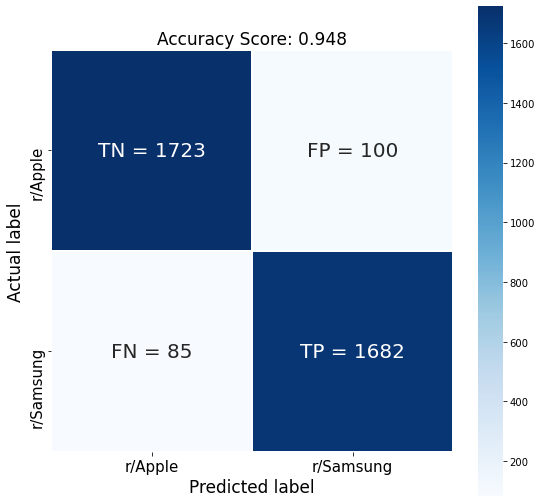

In [174]:
# Plot confusion matrix has been imported
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=np.array(modified_cm),
            fmt="",
            annot_kws={"size": 20},
            linewidths=.5,
            square = True,
            cmap = 'Blues',
            xticklabels = ['r/Apple', 'r/Samsung'],
            yticklabels = ['r/Apple', 'r/Samsung'],
            );

plt.ylabel('Actual label', fontsize = 17);
plt.xlabel('Predicted label', fontsize = 17);
plt.title('Accuracy Score: {:.3f}'.format(score), size = 17);
plt.tick_params(labelsize= 15)

# Save plot
plt.savefig('../plots/confusion_matrix.png', dpi=150, bbox_inches='tight')

**True Positive** : r/Samsung posts which were correctly predicted. 

**True Negative** : r/Apple posts which were correctly predicted. 

**False Positive** : r/Apple posts which were incorrectly predicted. 

**False Negative** : r/Samsung posts which were incorrectly predicted. 

###  Coefficients

In [175]:
# Check each step of the pipeline in our best model
# source: https://stackoverflow.com/questions/43856280/return-coefficients-from-pipeline-object-in-sklearn
tvec_lr_gs.best_estimator_.steps

[('tvec', TfidfVectorizer(max_df=0.3, min_df=3, stop_words='english')),
 ('lr', LogisticRegression(C=1, max_iter=1000, random_state=42))]

In [176]:
# Best model
best_mod = tvec_lr_gs.best_estimator_.steps[1][1]
best_mod

LogisticRegression(C=1, max_iter=1000, random_state=42)

In [177]:
# Store coefficients of model in a dataframe and rename columns as 'coef'
coefs = pd.DataFrame(best_mod.coef_).transpose()
coefs.columns = ['coef']
coefs['exp_coef'] = np.exp(coefs['coef'])

In [178]:
# Best vectorizer
best_vec = tvec_lr_gs.best_estimator_.steps[0][1]
best_vec

TfidfVectorizer(max_df=0.3, min_df=3, stop_words='english')

In [179]:
# Array mapping from feature integer indices to feature name
coefs['ngram'] = best_vec.get_feature_names()

As a recap from Part 2, we have set up the binary classes: 1 = r/Samsung 0 = r/Apple.

From the analysis of the coefficients of the model, the n-grams or words with the highest positive coefficients are those that have strongest predictive power with respect to r/Samsung. On the other hand, the n-grams or words with the highest negative coefficients are those that have strongest predictive power with respect to r/Apple. 

In [180]:
# Top Ngrams correlated with r/Samsung
top_ss_coefs = coefs.sort_values('exp_coef', ascending = False).head(15).reset_index(drop=True)
top_ss_coefs

,coef,exp_coef,ngram
0,16.012218,8.995343e+06,samsung
1,9.055124,8.562297e+03,galaxy
2,8.450611,4.677931e+03,s21
3,5.379227,2.168546e+02,s20
4,5.097546,1.636198e+02,ultra
5,4.330706,7.599795e+01,bud
6,3.677516,3.954802e+01,s10
7,3.442453,3.126355e+01,flip
8,3.427609,3.080291e+01,phone
9,3.388968,2.963534e+01,note


Overall, the common words that have the strongest correlation with r/Samsung are mainly the brand name, devices names and specific models(e.g. galaxy, s21, s20, s10, ultra, note, fold, flip, etc). This is consistent with the EDA.

**Interpretation of coefficient:**
For every one-unit increase in the word 'galaxy' (X-variable) in a post, the log-odds that the post is in r/Samsung class (Y-variable) increases by 16.01 times, all other variables are held constant.

Text(0.5, 1.0, 'Top 15 Ngrams Correlated with r/Samsung')

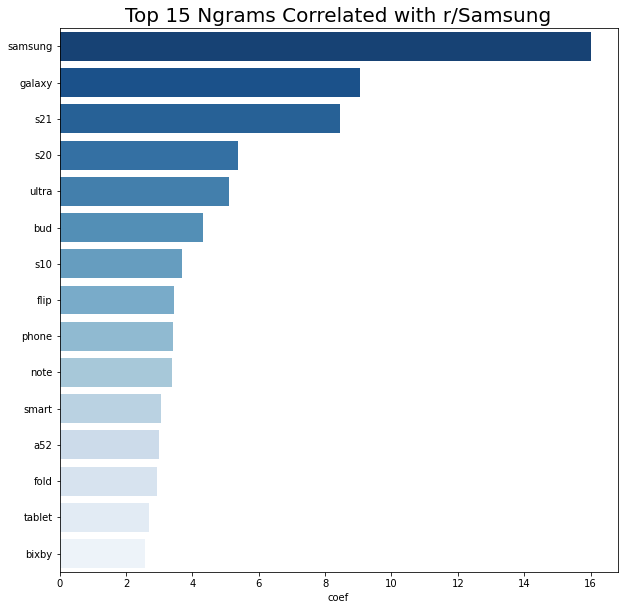

In [181]:
# Plot top Ngrams correlated with r/Samsung
plt.figure(figsize=(10,10))
sns.barplot(data=top_ss_coefs, x=top_ss_coefs['coef'], y='ngram', palette='Blues_r')
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with r/Samsung', fontsize=20)

In [182]:
# Top Ngrams correlated with r/Apple
top_ap_coefs = coefs.sort_values('exp_coef', ascending = False).tail(15).reset_index(drop=True)
top_ap_coefs

,coef,exp_coef,ngram
0,-2.736978,0.064766,macos
1,-2.741295,0.064487,airpod
2,-2.807282,0.060369,catalina
3,-2.849256,0.057887,mbp
4,-2.939296,0.052903,safari
5,-2.961873,0.051722,imac
6,-4.015710,0.018030,icloud
7,-4.048654,0.017446,pro
8,-4.794054,0.008279,mac
9,-5.184571,0.005602,ipad


Similarly, the common words that have the strongest correlation with r/Apple are mainly the brand name, product names (iphone, airpods, macbook, ipad, etc) and applications/operating systems that are only available to Apple (e.g. siri, icloud, catalina, etc). This is consistent with the EDA.

**Interpretation of coefficient:**
For every one-unit increase in the word 'iphone' (X-variable) in a post, the log-odds that the post is in r/Apple class (Y-variable) increases by 9.73 times, all other variables are held constant.

Text(0.5, 1.0, 'Top 15 Ngrams Correlated with r/Apple')

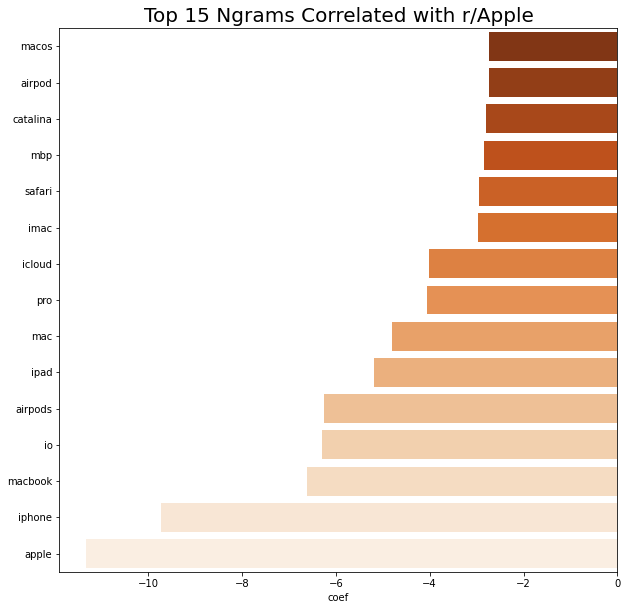

In [183]:
# Plot top Ngrams correlated with r/Apple
plt.figure(figsize=(10,10))
sns.barplot(data=top_ap_coefs, x= top_ap_coefs['coef'], y='ngram', palette='Oranges_r')
plt.ylabel('')
plt.title('Top 15 Ngrams Correlated with r/Apple', fontsize=20)

###  Area Under the Curve (AUC) of Receiver Operating Characteristic (ROC)  

Let's have a look at the AUC-ROC Curve to help us visualize how well our machine learning classifier is performing. 

The ROC curve is an evaluation metric for binary classification problems. It is a probability curve that plots the True Positive Rate against False Positive Rate at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The ROC curve is generated by varying our threshold from 0 to 1. This doesn't actually change the threshold or our original predictions, but it helps us to visualize our tradeoff between sensitivity and specificity and understand how well-separated our populations are.

The AUC is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

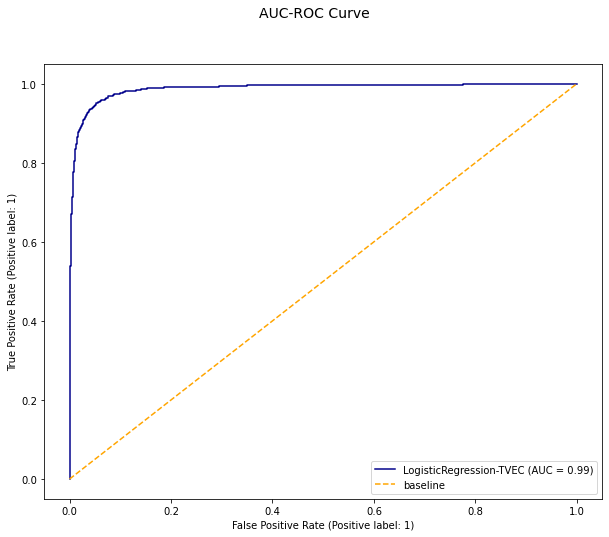

In [184]:
# Plot AUC-ROC Curve 
# Reference: Lesson codes 4.04 extra practice

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plot_roc_curve(tvec_lr_gs, X_test, y_test, name='LogisticRegression-TVEC', color='darkblue', ax=ax)
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--', color ='orange')
plt.suptitle('AUC-ROC Curve', fontsize = 14, )
plt.legend()

# Save plot
plt.savefig('../plots/auc_roc.png', dpi=150, bbox_inches='tight')

In [185]:
# Compute AUC
# Ref: https://stackoverflow.com/questions/31159157/different-result-with-roc-auc-score-and-auc
roc_auc_score(y_test, tvec_lr_gs.predict_proba(X_test)[:,1])

0.9865856047405333

We can see that our selected model is performing very well at distinguishing between the positive and negative classes. This is indicated by the AUC, which is close to 1. The classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.

###  Changing Prediction Threshold

In [186]:
# We will check out whether we could change our prediction threshold to a custom value
def get_predictions(probabilities, threshold):
    return [0 if prob < threshold else 1 for prob in probabilities]

In [187]:
threshold_list = [0.25, 0.4, 0.5, 0.6, 0.75]

for threshold in threshold_list:
    preds = get_predictions(tvec_lr_gs.predict_proba(X_test)[:,1], threshold)
    acc = accuracy_score(y_test, preds)
    print(f'Threshold: {threshold}, Accuracy: {acc}')

Threshold: 0.25, Accuracy: 0.8910863509749304
Threshold: 0.4, Accuracy: 0.9353760445682451
Threshold: 0.5, Accuracy: 0.9484679665738162
Threshold: 0.6, Accuracy: 0.9403899721448468
Threshold: 0.75, Accuracy: 0.8896935933147633


Based on the above, keeping our threshold at 0.5 is most ideal, with the highest accuracy.

## 6.Conclusion and Recommendations

As demonstrated above, we had selected **Logistic Regression with TF-IDF Vectorizer with hyperparameter tuning** as our best model for deployment to classify Samsung and Apple posts after scoring and evaluating all the models. 

The test dataset performed well, returning a accuracy score of 0.948468. It can also generalize unseen data well with the small difference in accuracy rate of 0.029710 between the 'train' and 'test' scores. 

There is also a strong improvement over the baseline accuracy score of 0.507799 by using the normalised prediction of all posts. 

However, the model has its limitations. As we deep-dived into the wrongly classified posts, posts mentioning switching of brand loyalty from Apple to Samsung or vice versa, are often misclassified. This shows that while r/Apple and r/Samsung are fairly different, they still hold some similarities.  

### Recommendations and Future Considerations

**1. Consider discussing Apple/ Samsung products in the magazine article**

Based on the model's coefficients, the common words that have the strongest predicting power in distinguishing the class are the brand names itself - 'Apple' and 'Samsung', followed by the words that are product-specific. These insights are also similarly observed in the EDA. The Editor-in-chief could consider including some of the latest products that are gaining traction in the magazine article since they are found to be widely discussed. 

**2. Re-run the model by including additional stopwords like brand names**

One of the future considerations is to re-run the model by including the brand names (i.e. 'Apple' and 'Samsung') as stopwords. It would be interesting to see how the model will perform if it disregards the brand names. The model could also surface other strong predictive words that were previously overshadowed by the brand names. 

**3. Deploy the text classifier to other tech forums**

As our model has learnt how to differentiate between 'Apple' and 'Samsung' posts on Reddit, the model can be deployed to other tech forums to help classify posts into the 2 classes. This can ease the burden of the technology journalists to a certain extent as it can help organise their research materials. 

**4. Perform sentiment analysis**

It is not enough to just listen to what people discuss online; it is more important to comprehend the meaning of the online texts. As seen from the Ngrams illustrations, the strong predictive words are primarily related to the product names, which are relatively neutral. More advanced text analytics or sentiment analysis could be conducted to uncover the hidden sentiments behind the online texts. The insights could provide some useful inspiration for the technology journalists' articles.